In [1]:
#prep data

In [2]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import numpy as np
import bs4
import time

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

from env import github_token, github_username

import acquire

In [3]:
df = pd.read_csv (r'f1_readmes.csv')

In [4]:
df.head()

,repo,language,readme_contents,written_language
0,ppatierno/formula1-telemetry-kafka,Java,# Formula 1 - Telemetry with Apache Kafka\n\nT...,en
1,NVIDIA-AI-IOT/Formula1Epoch,Makefile,[![logo.png](https://s2.postimg.org/fwiu26nmh/...,en
2,jcnewell/ergast-f1-api,PHP,# Ergast nodeJS API\nIn this period we are wor...,en
3,SOYJUN/FTP-implement-based-on-UDP,C,Copyright (c) 2014 Jun Zeng. <jun.zeng@stonybr...,en
4,daz/live-f1,C,live-f1 is a native Linux client for viewing t...,en


In [5]:


def clean_nlp(readme_contents):
    
    'A simple function to cleanup text data'
    
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', '\n', 'ha']
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('portuguese') + nltk.corpus.stopwords.words('spanish') + nltk.corpus.stopwords.words('french') + ADDITIONAL_STOPWORDS
    readme_contents = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', readme_contents).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
null_readme = df[df['readme_contents'].isnull()].index

In [7]:
type(null_readme)

pandas.core.indexes.numeric.Int64Index

In [8]:
df.drop(null_readme , inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              268 non-null    object
 1   language          241 non-null    object
 2   readme_contents   268 non-null    object
 3   written_language  268 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


In [10]:
#from textblob import TextBlob

In [11]:
# df['written_language'] = df['readme_contents'].apply(lambda content: TextBlob(content).detect_language())

In [12]:
df.written_language.value_counts()

en       223
pt        13
es         9
fr         6
ko         3
de         3
ro         2
zh-CN      2
pl         1
gl         1
ru         1
id         1
vi         1
nl         1
sl         1
Name: written_language, dtype: int64

In [13]:
# df.to_csv('f1_readmes.csv', index=False)

In [14]:
df.language.value_counts()

JavaScript          55
Python              28
HTML                20
Java                14
C++                 14
PHP                 14
TypeScript          13
C#                  13
Ruby                11
Jupyter Notebook     9
R                    8
C                    7
CSS                  7
Kotlin               4
Swift                3
Go                   2
Scala                2
PLpgSQL              2
Matlab               2
TSQL                 2
PLSQL                1
TeX                  1
Pascal               1
Dart                 1
F#                   1
Verilog              1
q                    1
Shell                1
SCSS                 1
Makefile             1
Visual Basic         1
Name: language, dtype: int64

In [15]:
drop_languages = df[df['language'].map(df['language'].value_counts()) < 7].index

In [16]:
df.drop(drop_languages , inplace=True)

In [17]:
df.written_language.value_counts()

en       199
pt        11
es         9
fr         6
ko         3
de         3
zh-CN      2
pl         1
ro         1
sl         1
id         1
vi         1
nl         1
gl         1
Name: written_language, dtype: int64

In [18]:
df = df[df['language'].notna()]

In [19]:
df.written_language.value_counts()

en       173
pt        11
es         8
fr         6
ko         3
de         3
zh-CN      2
pl         1
ro         1
sl         1
id         1
vi         1
nl         1
gl         1
Name: written_language, dtype: int64

In [20]:
drop_written_languages = df[df['written_language'].map(df['written_language'].value_counts()) < 4].index

In [21]:
df.drop(drop_written_languages , inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 267
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              198 non-null    object
 1   language          198 non-null    object
 2   readme_contents   198 non-null    object
 3   written_language  198 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


- I dropped for languages where I coulnd't  remove stop words
- I dropped where there were nulls in language
- i dropped langauges that had less than 7 total entries

In [23]:
df.language.value_counts()

JavaScript          50
Python              27
HTML                20
C++                 14
PHP                 13
Java                13
TypeScript          12
Ruby                11
C#                  10
Jupyter Notebook     9
R                    7
C                    6
CSS                  6
Name: language, dtype: int64

In [24]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
JavaScript,50,0.252525
Python,27,0.136364
HTML,20,0.101010
C++,14,0.070707
PHP,13,0.065657
Java,13,0.065657
TypeScript,12,0.060606
Ruby,11,0.055556
C#,10,0.050505
Jupyter Notebook,9,0.045455


In [25]:
# seperate the data into seperate pieces 

js = clean_nlp(' '.join(df[df.language == 'JavaScript'].readme_contents))

python = clean_nlp(' '.join(df[df.language == 'Python'].readme_contents))

html = clean_nlp(' '.join(df[df.language == 'HTML'].readme_contents))

php = clean_nlp(' '.join(df[df.language == 'PHP'].readme_contents))

cplus = clean_nlp(' '.join(df[df.language == 'C++'].readme_contents))

java = clean_nlp(' '.join(df[df.language == 'Java'].readme_contents))

csharp = clean_nlp(' '.join(df[df.language == 'C#'].readme_contents))

type_script = clean_nlp(' '.join(df[df.language == 'TypeScript'].readme_contents))

ruby = clean_nlp(' '.join(df[df.language == 'Ruby'].readme_contents))

r = clean_nlp(' '.join(df[df.language == 'R'].readme_contents))

c = clean_nlp(' '.join(df[df.language == 'C'].readme_contents))

all_words = clean_nlp(' '.join(df.readme_contents))

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 267
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              198 non-null    object
 1   language          198 non-null    object
 2   readme_contents   198 non-null    object
 3   written_language  198 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


In [27]:
df.language.value_counts()

JavaScript          50
Python              27
HTML                20
C++                 14
PHP                 13
Java                13
TypeScript          12
Ruby                11
C#                  10
Jupyter Notebook     9
R                    7
C                    6
CSS                  6
Name: language, dtype: int64

In [29]:
js_freq = pd.Series(js).value_counts()
python_freq = pd.Series(python).value_counts()
html_freq = pd.Series(html).value_counts()
php_freq = pd.Series(php).value_counts()
cplus_freq = pd.Series(cplus).value_counts()
java_freq = pd.Series(java).value_counts()
csharp_freq = pd.Series(csharp).value_counts()
type_script_freq = pd.Series(type_script).value_counts()
ruby_freq = pd.Series(ruby).value_counts()
r_freq = pd.Series(r).value_counts()
c_freq = pd.Series(c).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [30]:
word_counts = (pd.concat([all_freq,
                          js_freq,
                          python_freq,
                          html_freq,
                          php_freq,
                          cplus_freq,
                          java_freq,
                          csharp_freq,
                          type_script_freq,
                          ruby_freq,
                         r_freq,
                         c_freq,], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'html', 'php','cplus', 'java', 'cpound', 'typescript', 'ruby', 'r', 'c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(10)

,all,js,python,html,php,cplus,java,cpound,typescript,ruby,r,c
0,130,3,39,1,1,71,13,0,0,0,0,0
00,1,0,0,0,0,1,0,0,0,0,0,0
0000,15,0,0,0,0,13,0,0,2,0,0,0
000000,1,0,0,0,0,1,0,0,0,0,0,0
000030,1,0,0,0,0,1,0,0,0,0,0,0
000040,1,0,0,0,0,1,0,0,0,0,0,0
0001,10,0,0,0,0,10,0,0,0,0,0,0
0002,4,0,0,0,0,4,0,0,0,0,0,0
0003,5,0,0,0,0,5,0,0,0,0,0,0
0004,5,0,0,0,0,5,0,0,0,0,0,0


Text(0.5, 1.0, 'Proportion of JavaScript vs Python for the 20 most common words')

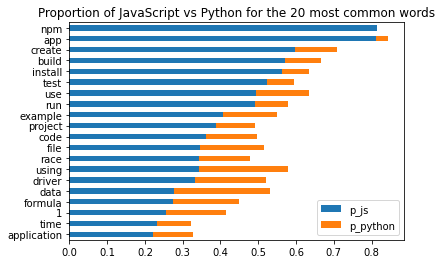

In [31]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_python=word_counts.python / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Python for the 20 most common words')

Text(0.5, 1.0, 'Proportion of Python vs HTML for the 20 most common words')

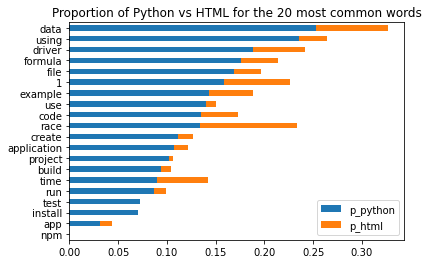

In [32]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_html']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs HTML for the 20 most common words')

Text(0.5, 1.0, 'Proportion of C++ vs Java for the 20 most common words')

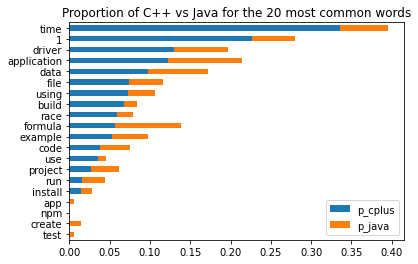

In [33]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_cplus=word_counts.cplus / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_cplus', 'p_java']]
 .tail(20)
 .sort_values('p_cplus')
 .plot.barh(stacked=True))

plt.title('Proportion of C++ vs Java for the 20 most common words')

Text(0.5, 1.0, 'Proportion of PHP vs Java for the 20 most common words')

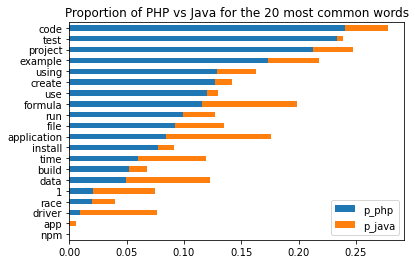

In [34]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_php=word_counts.php / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_php', 'p_java']]
 .tail(20)
 .sort_values('p_php')
 .plot.barh(stacked=True))

plt.title('Proportion of PHP vs Java for the 20 most common words')

Text(0.5, 1.0, 'Proportion of Python vs Java for the 20 most common words')

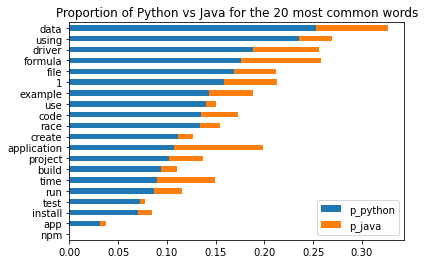

In [35]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_java']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs Java for the 20 most common words')

In [36]:
# convert javascript to one string

js = ' '.join([str(elem) for elem in js])

In [37]:
# bigrams for JavaScript

bigrams_js = nltk.ngrams(js.split(), 2)
top_20_js_bigrams = pd.Series(bigrams_js).value_counts().head(20)

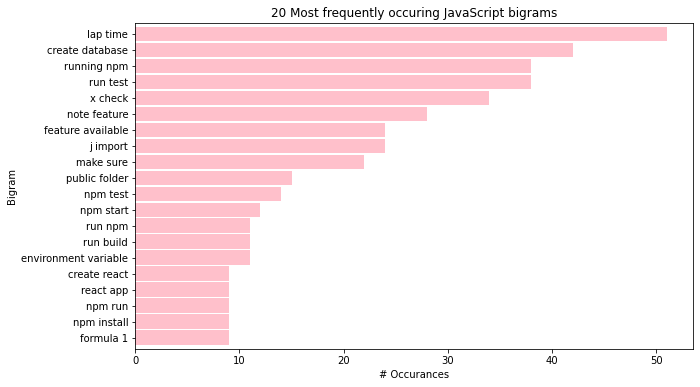

In [38]:
top_20_js_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [39]:
# convert python to one string

python = ' '.join([str(elem) for elem in python])



In [40]:
# bigrams for Python

bigrams_python = nltk.ngrams(python.split(), 2)
top_20_python_bigrams = pd.Series(bigrams_python).value_counts().head(20)

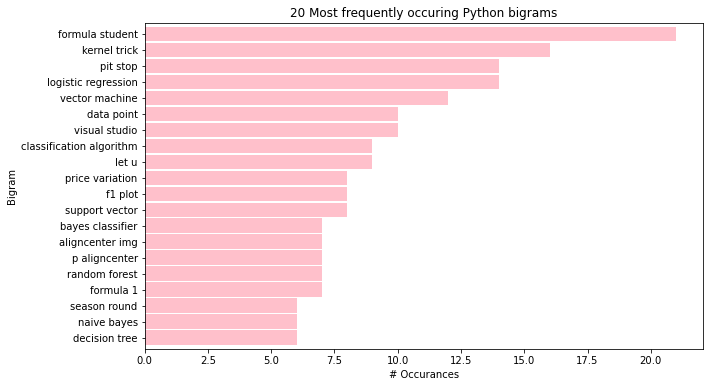

In [41]:
top_20_python_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [42]:
# convert html to one string

html = ' '.join([str(elem) for elem in html])

# bigrams for html

bigrams_html = nltk.ngrams(html.split(), 2)
top_20_html_bigrams = pd.Series(bigrams_html).value_counts().head(20)

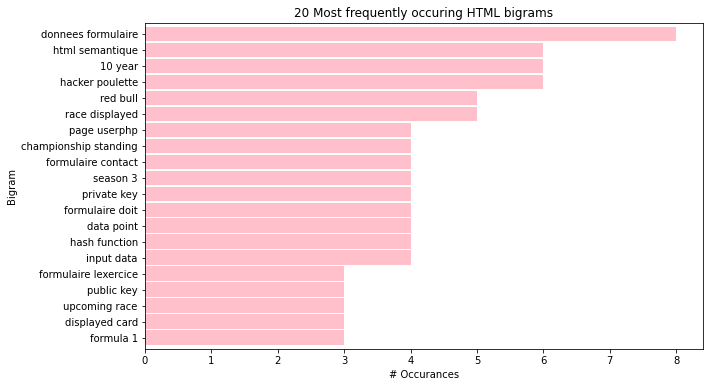

In [43]:
top_20_html_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [44]:
# convert cplus to one string

cplus = ' '.join([str(elem) for elem in cplus])

# bigrams for html

bigrams_cplus = nltk.ngrams(cplus.split(), 2)
top_20_cplus_bigrams = pd.Series(bigrams_cplus).value_counts().head(20)

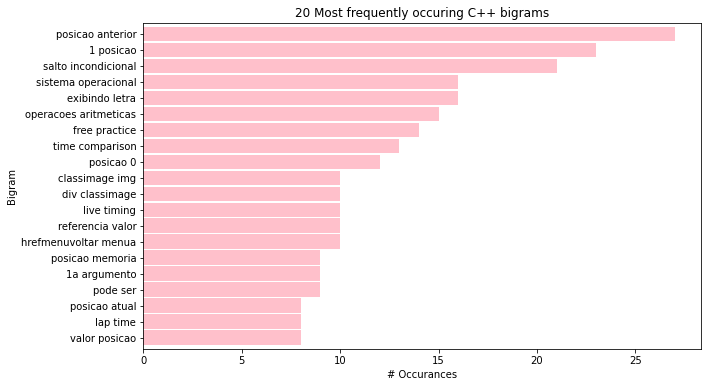

In [45]:
top_20_cplus_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C++ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_cplus_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [46]:
df.groupby('language').written_language.value_counts().to_frame()

written_language
language         written_language                  
C                en                               6
C#               en                              10
C++              en                              13
                 pt                               1
CSS              en                               4
                 es                               2
HTML             en                              12
                 es                               3
                 fr                               3
                 pt                               2
Java             en                              11
                 pt                               2
JavaScript       en                              46
                 es                               2
                 pt                               2
Jupyter Notebook en                               9
PHP              en                              10
                 fr                               3
Python           en                              25
                 pt                               2
R                en                               6
                 pt                               1
Ruby             en                              11
TypeScript       en                              10
                 es                               1
                 pt                               1

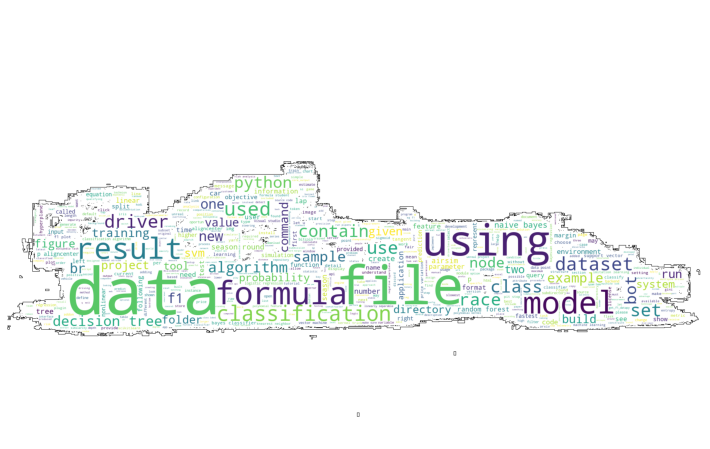

In [73]:
from wordcloud import WordCloud
from PIL import Image

plt.figure(figsize=(16,8))
mask = np.array(Image.open('racecar.jpeg'))
img = WordCloud(background_color="white", mask=mask,contour_color='black', contour_width=.01,
                max_words=1250, max_font_size=256,
                random_state=42, width=800, height=800).generate(python)

# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

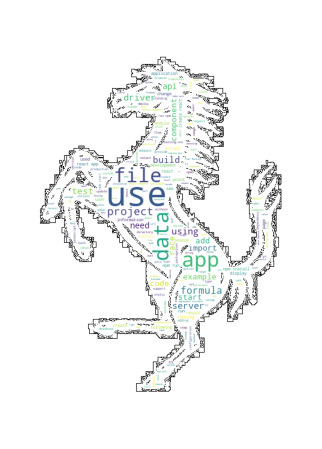

In [70]:
plt.figure(figsize=(16,8))
mask = np.array(Image.open('ferrari.jpeg'))
img = WordCloud(background_color="white", mask=mask,contour_color='black', contour_width=.5,
                max_words=1250, max_font_size=256,
                random_state=42, width=800, height=800).generate(js)

# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

In [ ]:
js_img = WordCloud(background_color='white').generate(js)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(js_img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

In [ ]:
cplus_img = WordCloud(background_color='white').generate(cplus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(cplus_img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

In [ ]:
df.written_language.value_counts()